# Rain prediction in Australia

This notebook follows work done (originally in R) as a final project for the **Statistical Learning** postgraduate course taught at FI-UBA. Given a number of weather observations, the task is to determine whether or not it will rain tomorrow (Binary classification problem).

Notes: 
1. There is no reassurance on whether the task is feasible or not.
2. Decisions taken must be justified.
3. The *Risk-MM* variable is leaky and should therefore be excluded.

Dataset and a description of the different variables are available [here](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package).

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

sns.set_theme()

In [89]:
df = pd.read_csv("data/weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [90]:
# drop the leaky variable
df.drop(columns=['RISK_MM'], inplace=True)

In [91]:
# parse the Date variable as datetime
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")

In [92]:
# high level description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142193 non-null  datetime64[ns]
 1   Location       142193 non-null  object        
 2   MinTemp        141556 non-null  float64       
 3   MaxTemp        141871 non-null  float64       
 4   Rainfall       140787 non-null  float64       
 5   Evaporation    81350 non-null   float64       
 6   Sunshine       74377 non-null   float64       
 7   WindGustDir    132863 non-null  object        
 8   WindGustSpeed  132923 non-null  float64       
 9   WindDir9am     132180 non-null  object        
 10  WindDir3pm     138415 non-null  object        
 11  WindSpeed9am   140845 non-null  float64       
 12  WindSpeed3pm   139563 non-null  float64       
 13  Humidity9am    140419 non-null  float64       
 14  Humidity3pm    138583 non-null  float64       
 15  

So far we have:

* A date column we can split into several variables (year, month, day), even possibly retrieve past values and treat as a TS
* Several missing values for many variables
* Both categorical (4) and numerical (16) variables
* Probably highly-correlated families of variables (e.g. Cloud9am-Cloud3pm-Sunshine)

In [93]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


## Missing data

Before splitting the data in train and test/validation sets we want to consider missing values for variables.

In [94]:
# get fraction of NAs by variable
NA_fraction_by_variable = df.isna().mean(axis=0)
NA_fraction_by_variable

Date             0.000000
Location         0.000000
MinTemp          0.004480
MaxTemp          0.002265
Rainfall         0.009888
Evaporation      0.427890
Sunshine         0.476929
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir9am       0.070418
WindDir3pm       0.026570
WindSpeed9am     0.009480
WindSpeed3pm     0.018496
Humidity9am      0.012476
Humidity3pm      0.025388
Pressure9am      0.098556
Pressure3pm      0.098324
Cloud9am         0.377353
Cloud3pm         0.401525
Temp9am          0.006358
Temp3pm          0.019171
RainToday        0.009888
RainTomorrow     0.000000
dtype: float64

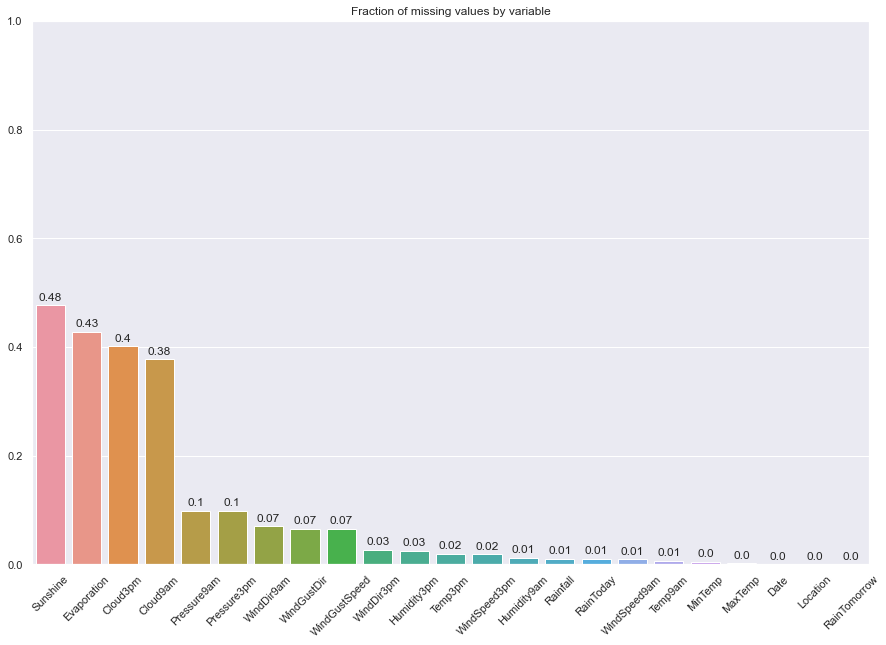

In [95]:
# utility function
def annotate_bars(ax, round_decs=0):
    for patch in ax.patches:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        ax.annotate(int(y) if round_decs==0 else round(y,round_decs),
                    xy=(x,y), 
                    xytext=(0,8),
                    textcoords='offset points',
                    ha='center', va='center')

# plot fraction of NAs by variable
fig, ax = plt.subplots(figsize=(15,10))

ordered_NAs_by_var = NA_fraction_by_variable.sort_values(ascending=False)

ax = sns.barplot(y=ordered_NAs_by_var, x=ordered_NAs_by_var.index, ax=ax)

ax.set_ylim(0,1)
ax.set_title("Fraction of missing values by variable")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
annotate_bars(ax, round_decs=2)

plt.show()

Some quick insights from the plot and the raw values from before:

* The target variable (*RainTomorrow*) has no missing values, so no observations need to be dropped because of this.
* Same with *Date* and *Location*.
* There are 4 variables for which there's a pretty high NA fraction (>1/3, one at almost 1/2) and then there's a long tail of variables with far more available values (all <= 0.1). This suggests the possibility of dropping those 4 "problematic" variables and perform imputation on the others.
* The same fat tail raises the question of whether there's a small group of observations with lots of missing values that can be dropped in order to solve almost all problems of missing values.

In [96]:
# number of variables with missing values by row, sort it descendingly by value like before
NA_count_by_row = (df.isna()
                   .sum(axis=1)
                   .value_counts()
                   .sort_values(ascending=False))
NA_count_by_row

0     56420
4     28540
2     18033
1     10765
6      9938
3      9611
5      3642
7      1801
8       964
12      757
11      679
9       394
10      290
13      106
17       91
18       49
14       39
16       27
15       26
19       16
20        5
dtype: int64

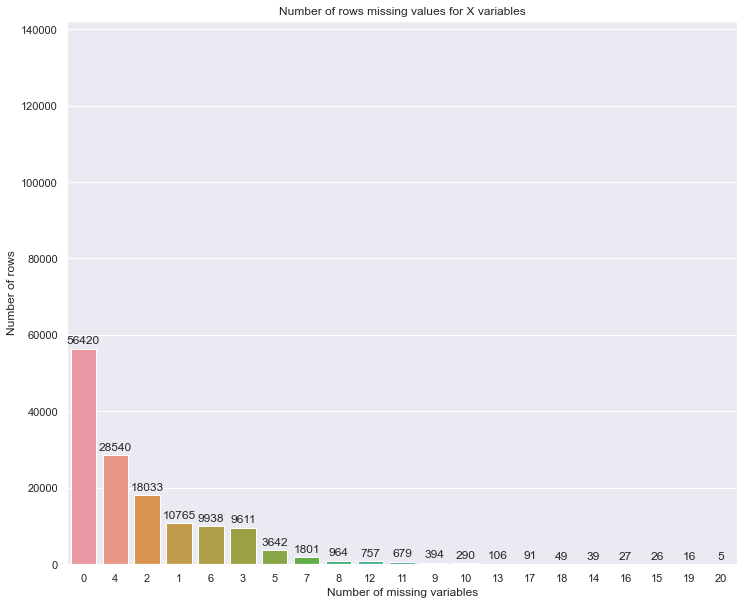

In [97]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(y=NA_count_by_row, x=NA_count_by_row.index, order=NA_count_by_row.index, ax=ax)
ax.set_title("Number of rows missing values for X variables")
ax.set_xlabel("Number of missing variables")
ax.set_ylabel("Number of rows")
ax.set_ylim(0,len(df))
annotate_bars(ax)
plt.show()

1. Removing all rows with NAs still retains around 40% of the dataset. This option would allow exploring all interactions between variables and a complete feature selection
2. There's no such small group of rows lacking the majority of variables that present NAs, as such row removal will not solve the problem. Given the large number of rows with 2-4 missing values it does seem advantageous though to take a compromise approach of first dropping the 4 high-NA variables above mentioned and *then* remove rows with missing values.
3. A last approach can dropping said 4 variables but imput all missing values afterwards instead of removing rows, keeping the full length of the dataset. 

We will call sets resulting from these approaches Set1, Set2 and Set3.

In [98]:
# separate the date into day, month and year
df['day'] = df.Date.dt.day
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df.drop(columns=['Date'], inplace=True)

In [99]:
set1 = df.dropna().copy()
print(f"Set1 has {len(set1)} rows, retaining {round(len(set1)/len(df),2)*100}% of the original dataset observations")

Set1 has 56420 rows, retaining 40.0% of the original dataset observations


In [100]:
high_NA_variables = ['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am']
set2 = df.drop(columns=high_NA_variables).dropna().copy()
print(f"Set2 has {len(set2)} rows, retaining {round(len(set2)/len(df),2)*100}% of the original dataset observations")

Set2 has 112925 rows, retaining 79.0% of the original dataset observations


Set3 will not be done yet as a further analysis for optimal imputation policy on each variable is required. Set2 also retains ~80% of the dataset, so the improvement will probably not be as significant.

Work will be first done on set1, on the hypothesis that it's representative of the original dataset. It will be then repeated on set2 for validations, and conclusions may be drawn.

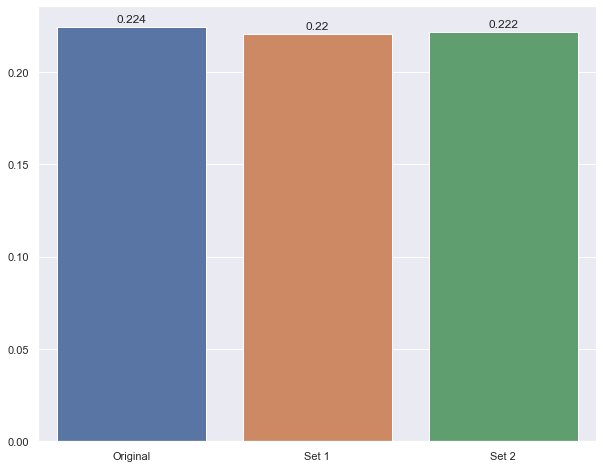

In [101]:
# are the datasets balanced?
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(y=[(dataset.RainTomorrow == "Yes").mean() for dataset in [df, set1, set2]],
            x=["Original", "Set 1", "Set 2"], 
            ax=ax)
annotate_bars(ax,round_decs=3)
plt.show()

* All sets preserve pretty much the same fraction of rainy days
* The dataset is very imbalanced: only 20% of the observations are positive cases

## Encoding

### Binary

In [102]:
# manually turn this binary variable into a 0-1 variable
set1.RainTomorrow = (set1.RainTomorrow == "Yes").astype(int)
set1.RainToday = (set1.RainToday == "Yes").astype(int)
set1.RainTomorrow.value_counts(), set1.RainToday.value_counts()

(0    43993
 1    12427
 Name: RainTomorrow, dtype: int64,
 0    43958
 1    12462
 Name: RainToday, dtype: int64)

### Numerical variables

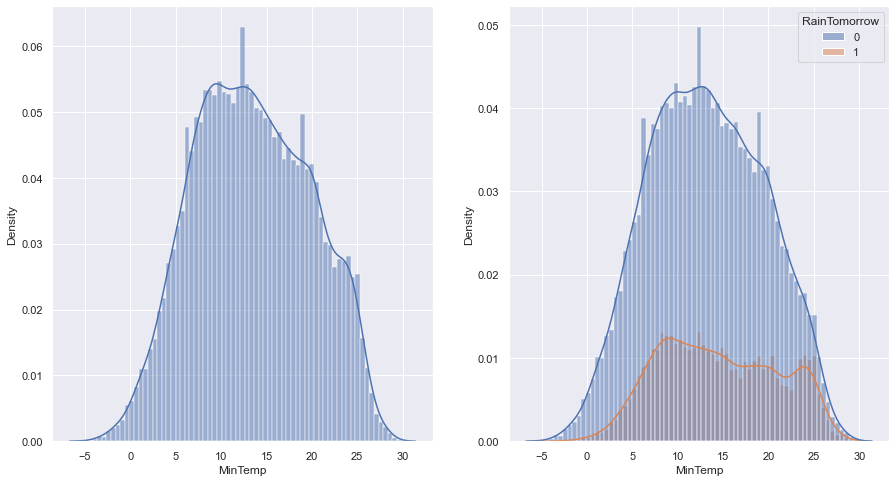

In [103]:
# mintemp
# min daily temp, in ºC
def plot_num_var(data, var, figsize=(15,8)):
    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(15,8))

    sns.histplot(data=data, x=var, stat="density", kde=True, ax=ax1)
    sns.histplot(data=data, x=var, stat="density", kde=True, ax=ax2, hue="RainTomorrow")
    plt.show()

plot_num_var(set1, "MinTemp")

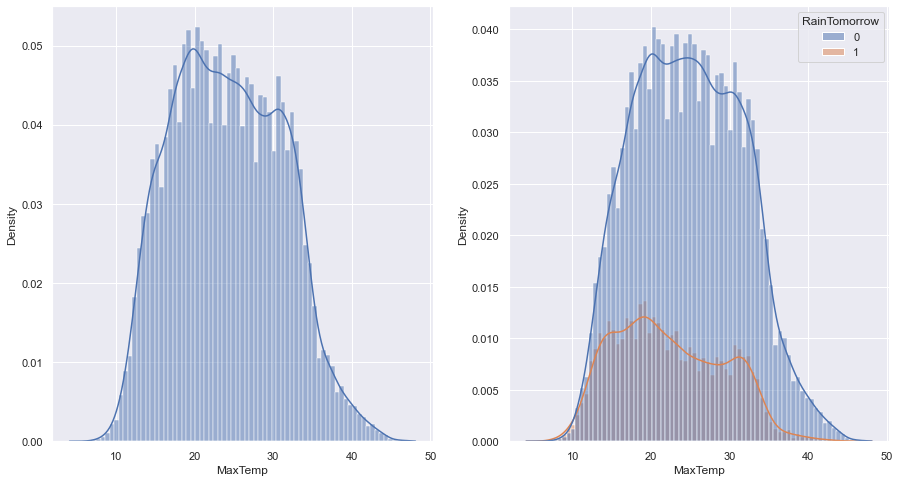

In [104]:
# maxtemp
# max daily temp, in ºC
plot_num_var(set1, "MaxTemp")

Both temp distributions seem fine, rainy days seem to have min and max temperatures closer together (less extreme min and max temp values). Makes sense from a water-acting-as-regulator perspective.

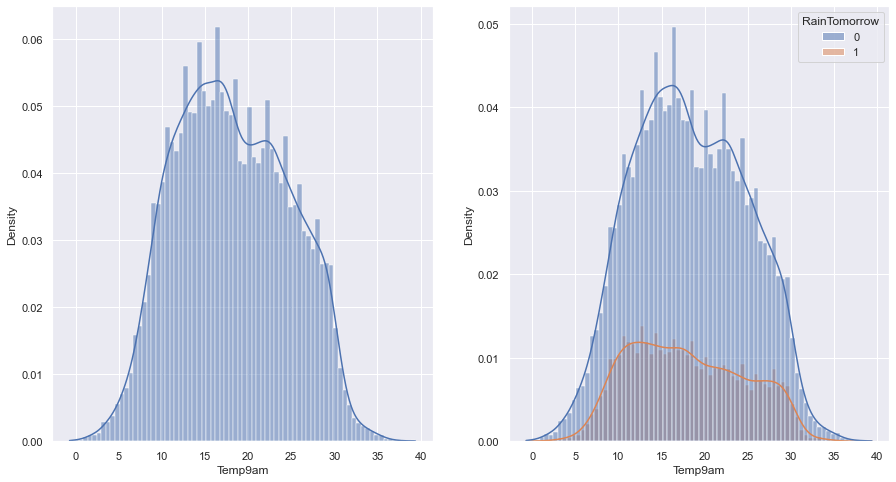

In [105]:
# temperatures
# measured at 9am and 3pm respectively, in ºC
plot_num_var(set1, "Temp9am")

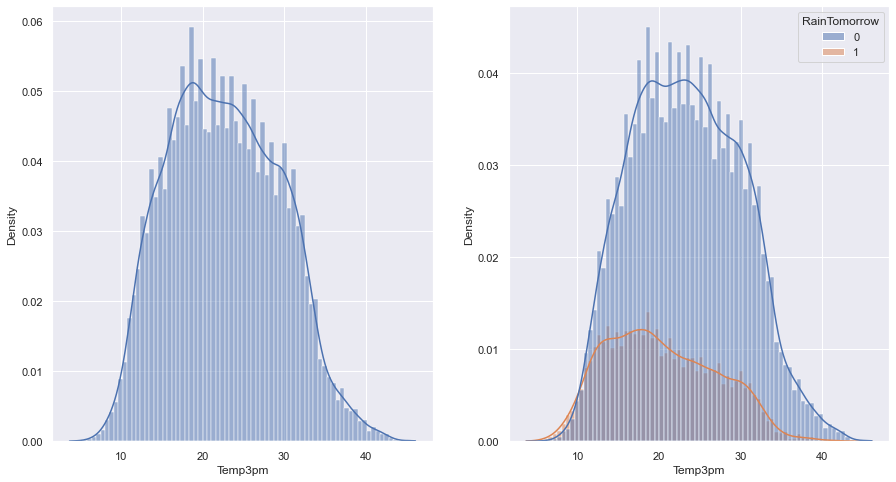

In [106]:
plot_num_var(set1, "Temp3pm")

Both temperature distributions seem to be well behaved yet have low predictive power, at least by themselves.

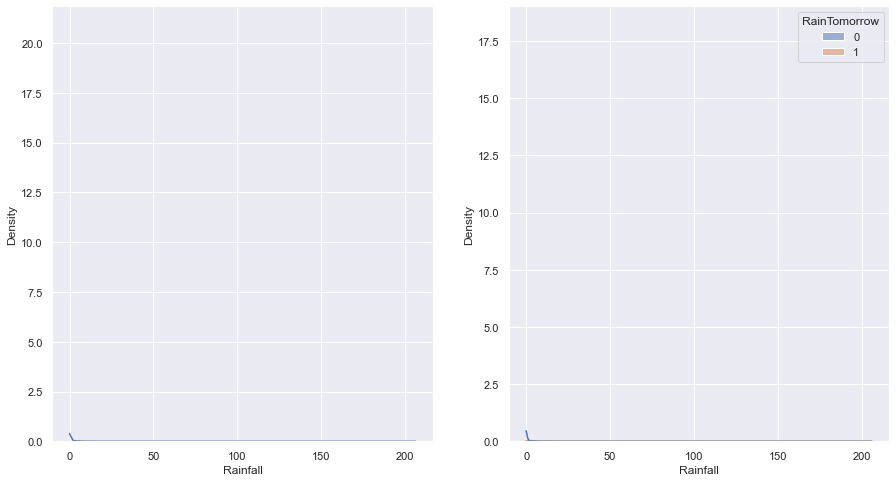

In [107]:
# rainfall
# rain volume registered in given day, in mm
plot_num_var(set1, "Rainfall")

There seems to be a huge accumulation in the 0 region. Checking quartiles in the describe() method shows 0, 0.25 and 0.5 quantiles are all 0 and 0.75 quantile is 0.8, but max is 371. So there may be either some outliers, invalid data or just a small tail of large values. 
Plotting (shifted to prevent 0 division) log-scaled var should show which case it is:

<AxesSubplot:xlabel='Rainfall', ylabel='Count'>

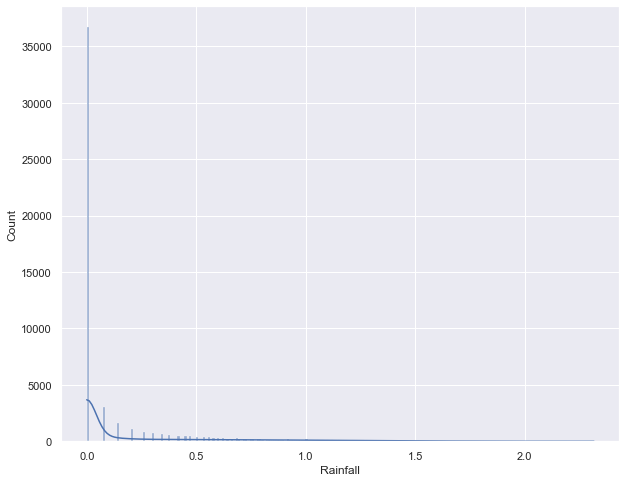

In [108]:
shifted_log_rainfall = np.log10(set1.Rainfall+1)
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(x=shifted_log_rainfall, stat="count", kde=True)

<AxesSubplot:xlabel='Rainfall', ylabel='Proportion'>

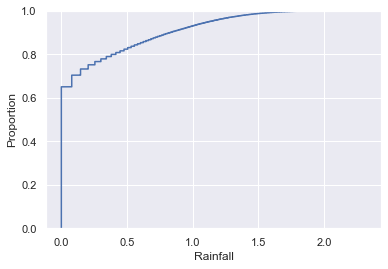

In [109]:
sns.ecdfplot(x=shifted_log_rainfall)

* More than 60% of *Rainfall* values are 0
* There are some disperse values in the (0, 0.5) range (for log10 scale) and then a continuum of exponentially larger values. For predictive purposes there's no need for transformation because the tail is not really heavy, but inference would probably require a box-cox transformation (most probably log)

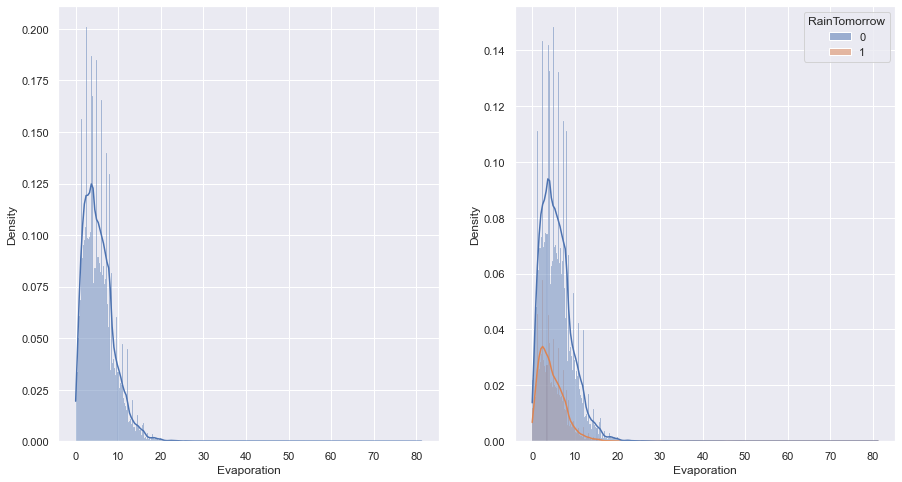

In [110]:
# evaporation
# evaporated water volume in given day, in mm
plot_num_var(set1, "Evaporation")

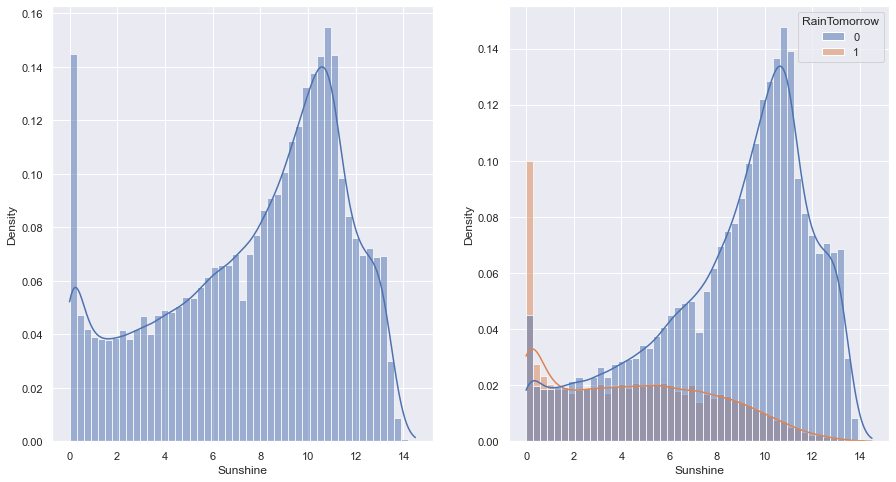

In [111]:
# sunshine
# number of hours with sun
plot_num_var(set1, "Sunshine")

The difference between the conditional distributions of Sunshine given RainTomorrow would suggest that *Sunshine* (or some highly correlated variable) might be a good predictor.

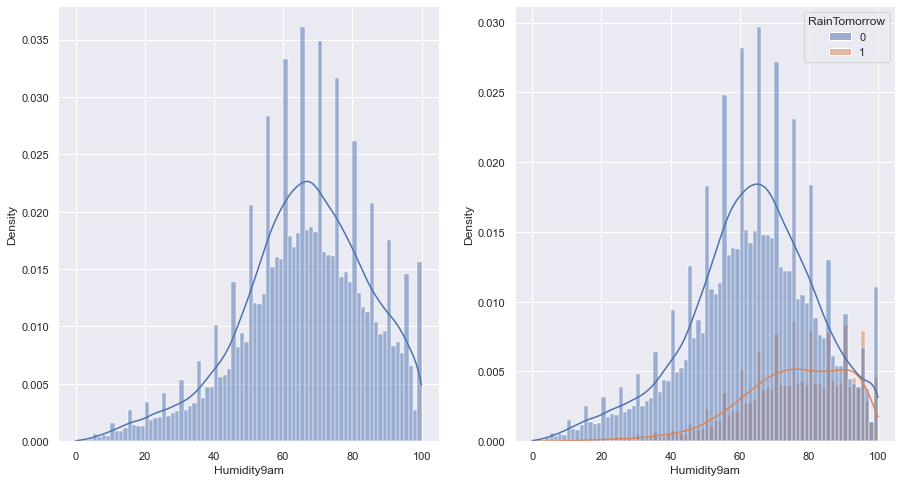

In [112]:
# humidities
# % humidity, measured at 9am and 3pm respectively, both in %
plot_num_var(set1, "Humidity9am")

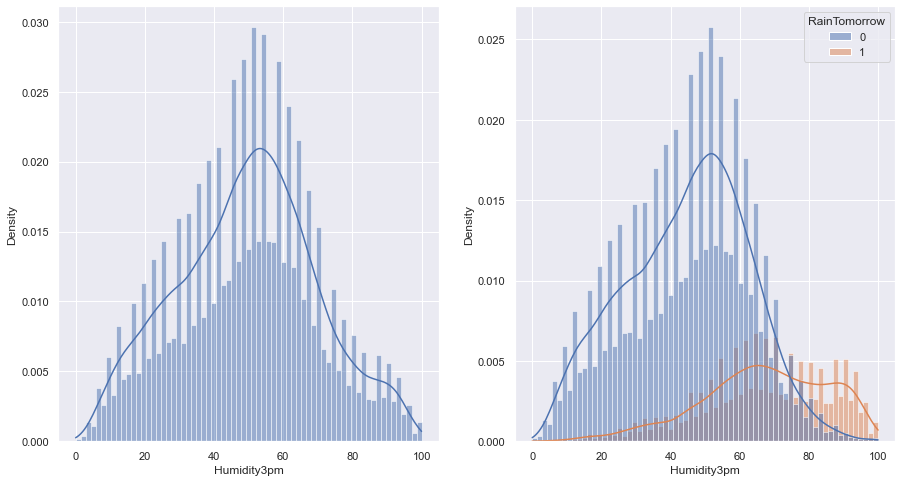

In [113]:
plot_num_var(set1, "Humidity3pm")

Naturally low values of Humidity (specially in the afternoon) suggest a lower chance of rain in the following day.

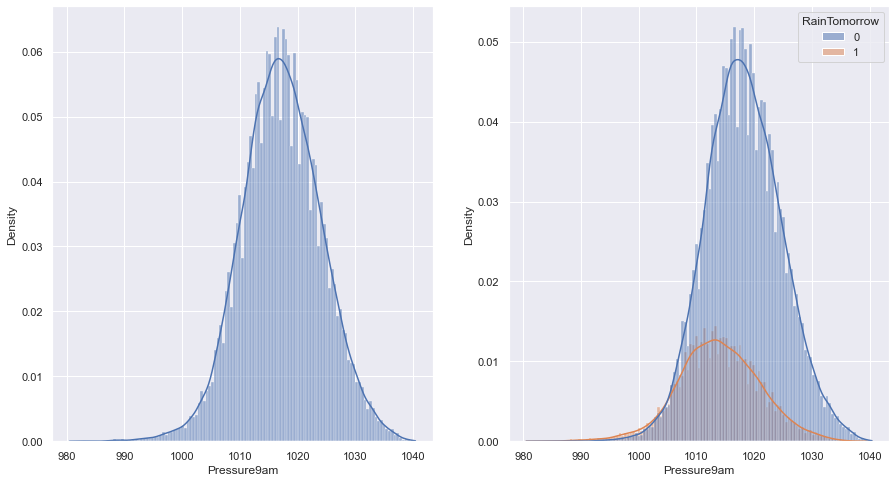

In [114]:
# pressures
# pressure measured at 9am and 3pm respectively, in hPa
plot_num_var(set1, "Pressure9am")

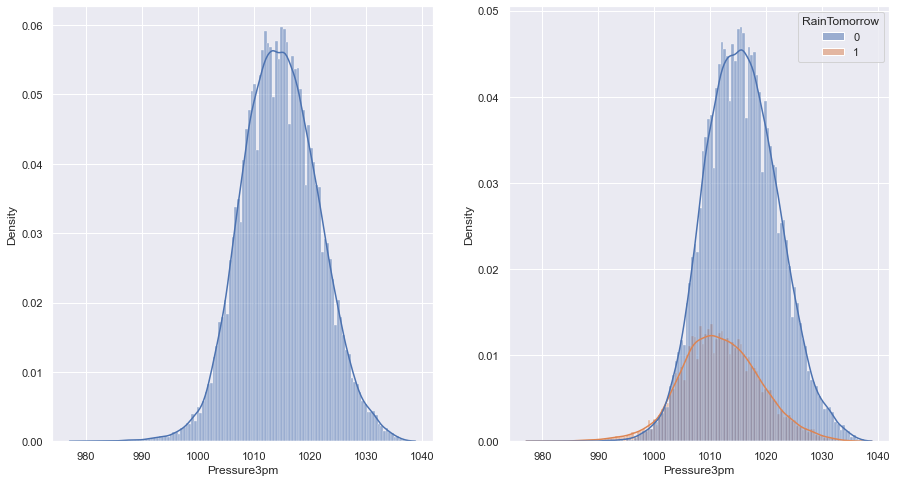

In [115]:
plot_num_var(set1, "Pressure3pm")

* Pretty well behaved distributions although values are a little high, might need to standardize if coefficients look unstable in regression
* There seems to be a different mean for pressures conditioned to RainTomorrow

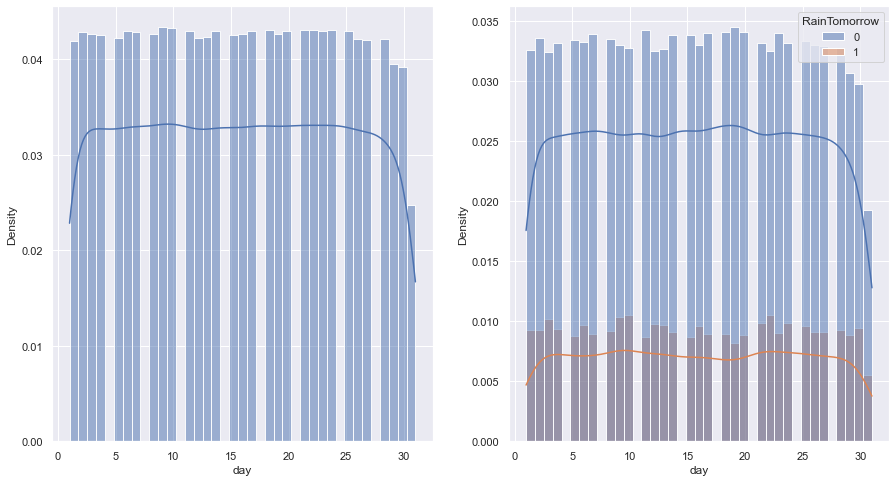

In [116]:
# date variables
# not expecting to have good predictive power as standalone variables, should be decent when paired (e.g. (day,month))
plot_num_var(set1, "day")

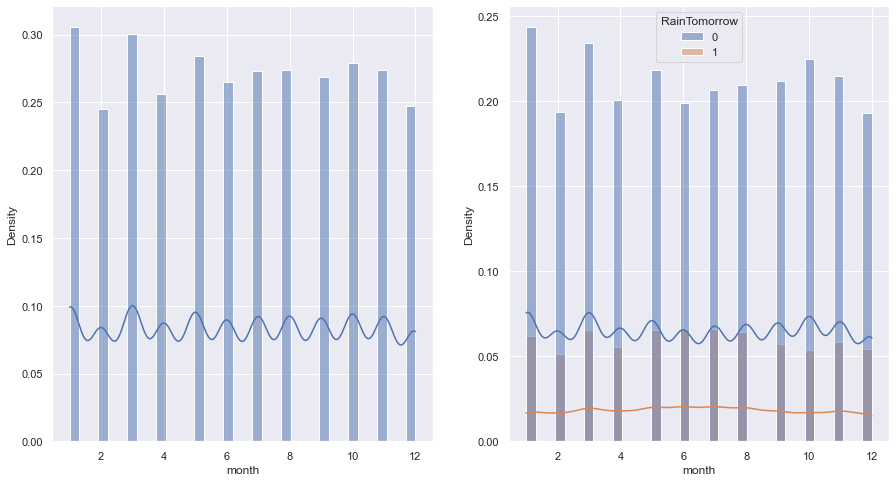

In [117]:
plot_num_var(set1, "month")

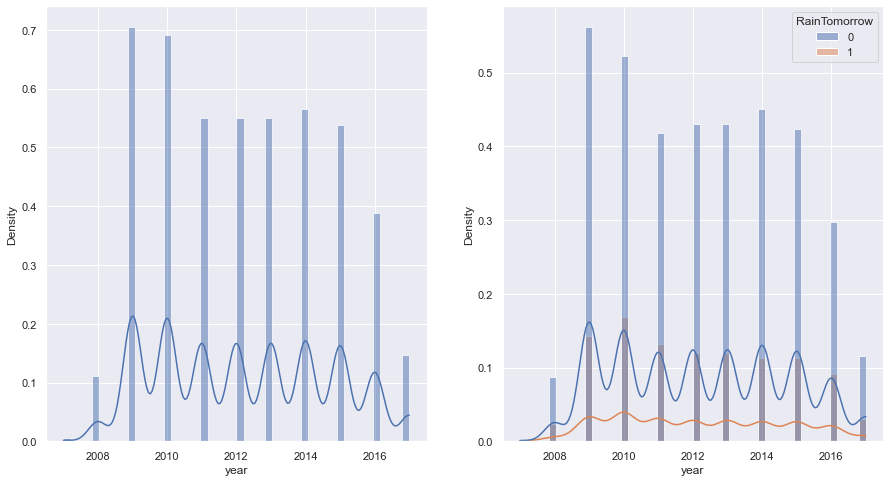

In [118]:
plot_num_var(set1, "year")

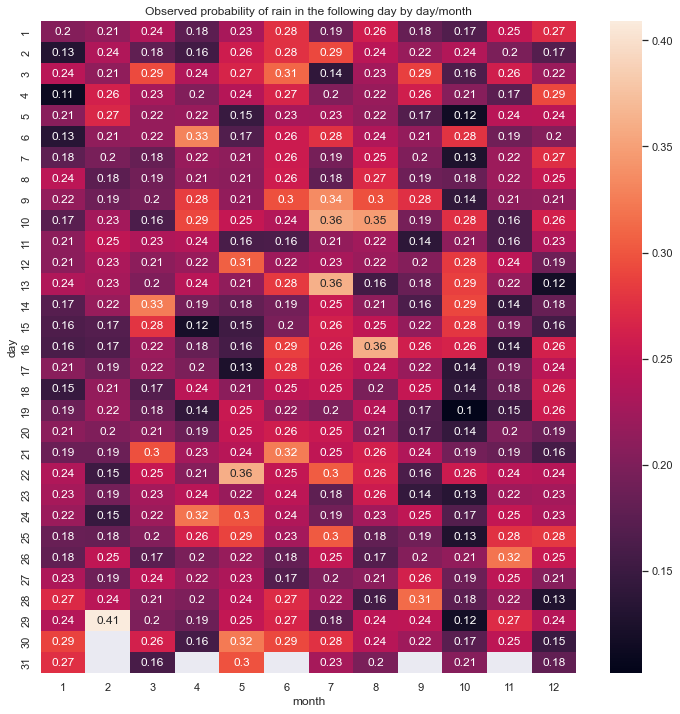

In [119]:
fig, ax = plt.subplots(figsize=(12,12))

# this doesnt work because month and day are discrete variables
# sns.scatterplot(data=set1, x="day", y="month", hue="RainTomorrow", ax=ax)

mean_rain_by_month_day = set1.pivot_table(values="RainTomorrow",index="day",columns="month",aggfunc="mean")

sns.heatmap(mean_rain_by_month_day, ax=ax, annot=True)
ax.set_title("Observed probability of rain in the following day by day/month")
plt.show()

While some pairs present higher odds of rain, there are almost no clear (vertical) zones with significant difference over the average (0.22). 10-16 of october is a candidate, but models may know better.

In [120]:
# winds
# winds have a special encoding which is basically polar coordinates, with discrete argument i.e. direction can only take 8 values:
unique_dirs = [set(set1[x_dir].unique()) for x_dir in ["WindGustDir", "WindDir9am", "WindDir3pm"]]
unique_dirs

[{'E',
  'ENE',
  'ESE',
  'N',
  'NE',
  'NNE',
  'NNW',
  'NW',
  'S',
  'SE',
  'SSE',
  'SSW',
  'SW',
  'W',
  'WNW',
  'WSW'},
 {'E',
  'ENE',
  'ESE',
  'N',
  'NE',
  'NNE',
  'NNW',
  'NW',
  'S',
  'SE',
  'SSE',
  'SSW',
  'SW',
  'W',
  'WNW',
  'WSW'},
 {'E',
  'ENE',
  'ESE',
  'N',
  'NE',
  'NNE',
  'NNW',
  'NW',
  'S',
  'SE',
  'SSE',
  'SSW',
  'SW',
  'W',
  'WNW',
  'WSW'}]

In [121]:
# they are all the same 16 possible directions
unique_dirs[0] == unique_dirs[1], unique_dirs[1] == unique_dirs[2], len(unique_dirs[0])

(True, True, 16)

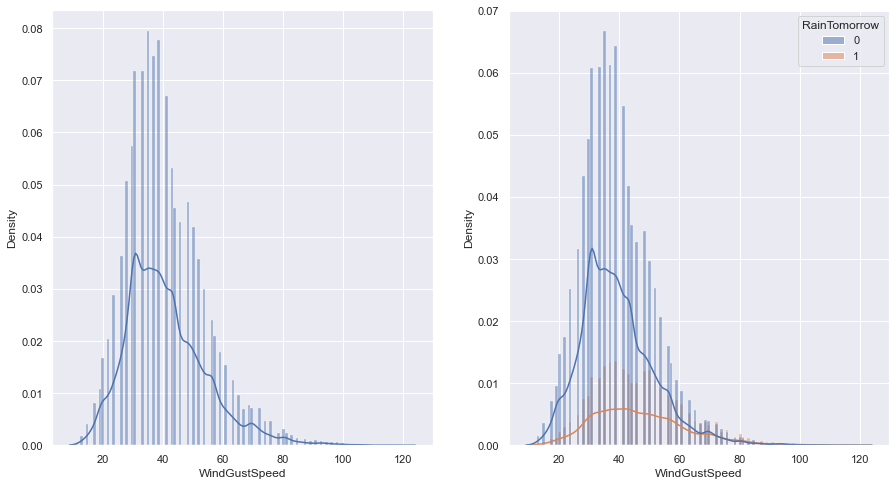

In [122]:
# this raises the question of whether it's better to conver these 3 wind variables to cartesian coordinates 
# or keep the polar ones

# checking whether the module is a good predictor
plot_num_var(set1, "WindGustSpeed")

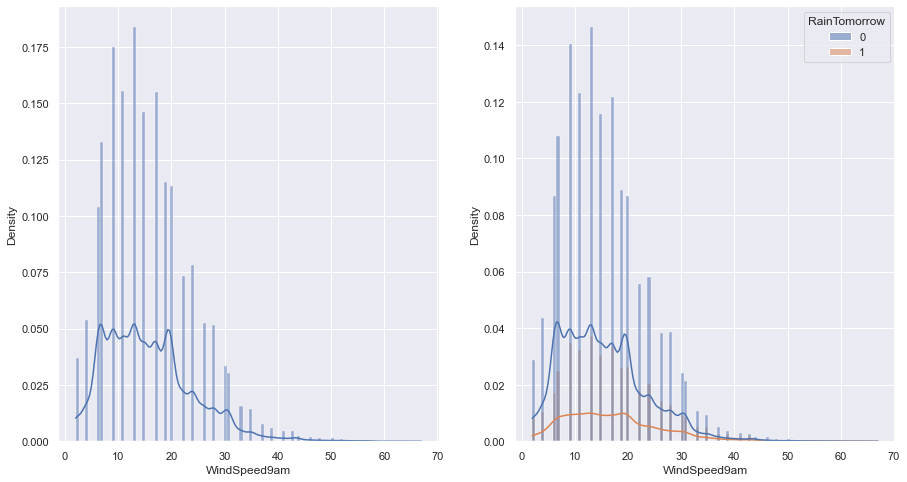

In [123]:
plot_num_var(set1, "WindSpeed9am")

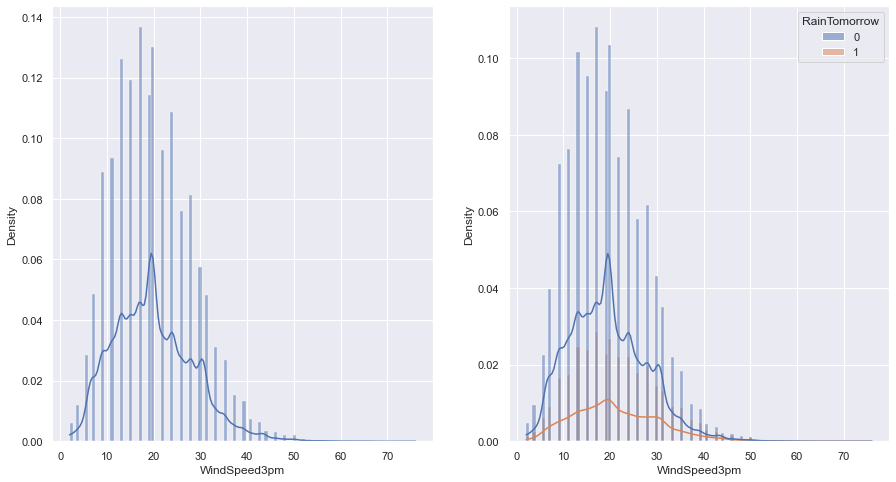

In [124]:
plot_num_var(set1, "WindSpeed3pm")

In [125]:
# none of them seem to be good predictors so transforming these to cartesian coordinates:
# cos(arg), sin(arg) for each argument
sorted_compass_points = ["N","NNE", "NE", "ENE", 
                         "E", "ESE", "SE", "SSE",
                         "S", "SSW", "SW", "WSW",
                         "W", "WNW", "NW", "NNW"]

# angle distance will be the complete circle angle divided by how many pieces we have
# using radians for numpy compatibility
angle_distance = 2*np.pi / len(sorted_compass_points)
print(f"Angle distance between compass points is ~{angle_distance:.3f} radians")

compass_to_angle = {compass: idx*angle_distance for idx, compass in enumerate(sorted_compass_points)}
print("Compass to angle[radians] encoder:")
print(compass_to_angle)


# here we're *assuming* dict access is faster than computation
def polar_winds_to_cartesian(dataset):
    speeds = ["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm"]
    dirs = ["WindGustDir", "WindDir9am", "WindDir3pm"]
    names_n = ["WindGust_N", "Wind9am_N", "Wind3pm_N"]
    names_e = ["WindGust_E", "Wind9am_E", "Wind3pm_E"]
    
    for w_speed, w_dir, w_n, w_e in zip(speeds, dirs, names_n, names_e):
        angles = dataset[w_dir].apply(lambda compass: compass_to_angle[compass])
        dataset[w_n] = np.cos(angles) * dataset[w_speed]
        dataset[w_e] = np.sin(angles) * dataset[w_speed]

Angle distance between compass points is ~0.393 radians
Compass to angle[radians] encoder:
{'N': 0.0, 'NNE': 0.39269908169872414, 'NE': 0.7853981633974483, 'ENE': 1.1780972450961724, 'E': 1.5707963267948966, 'ESE': 1.9634954084936207, 'SE': 2.356194490192345, 'SSE': 2.748893571891069, 'S': 3.141592653589793, 'SSW': 3.5342917352885173, 'SW': 3.9269908169872414, 'WSW': 4.319689898685965, 'W': 4.71238898038469, 'WNW': 5.105088062083414, 'NW': 5.497787143782138, 'NNW': 5.890486225480862}


In [126]:
polar_winds_to_cartesian(set1)
set1.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,RainTomorrow,day,month,year,WindGust_N,WindGust_E,Wind9am_N,Wind9am_E,Wind3pm_N,Wind3pm_E
5939,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,0,1,1,2009,-44.346218,-1.836880e+01,2.296101,5.543277,-14.142136,-14.142136
5940,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,0,2,1,2009,-37.000000,4.531193e-15,-17.553711,7.270985,-17.553711,7.270985
5942,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,0,4,1,2009,42.498458,1.760344e+01,27.716386,11.480503,13.858193,-5.740251
5943,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,0,5,1,2009,11.863186,-2.864027e+01,2.296101,-5.543277,-2.296101,-5.543277
5944,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,...,0,6,1,2009,13.393920,-3.233578e+01,12.020815,-12.020815,4.974885,-12.010434


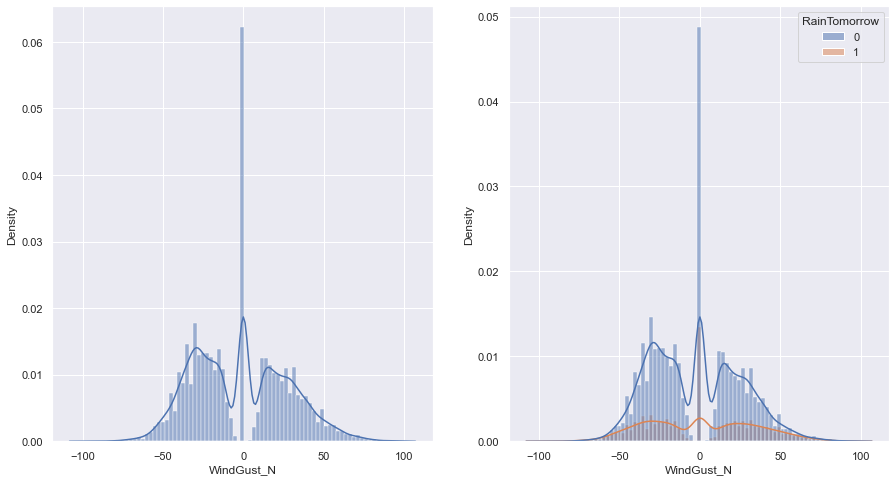

In [132]:
# now plot these cartesian coordinates
plot_num_var(set1, "WindGust_N")

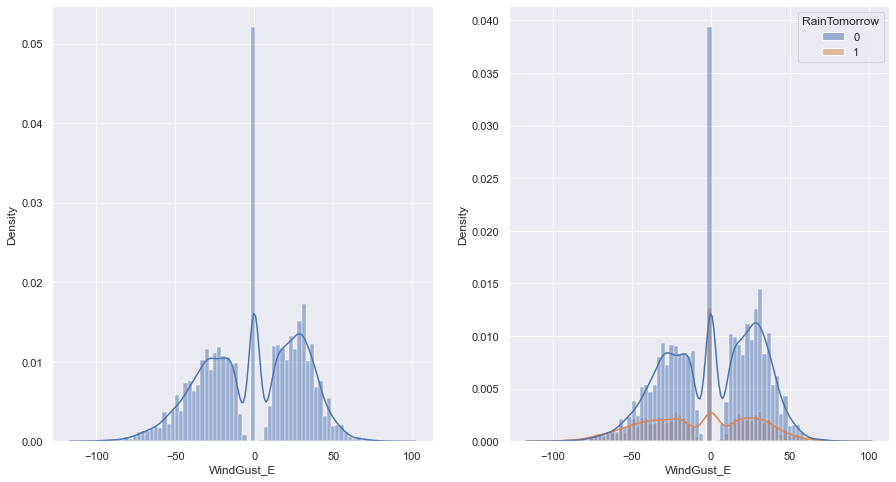

In [128]:
plot_num_var(set1, "WindGust_E")

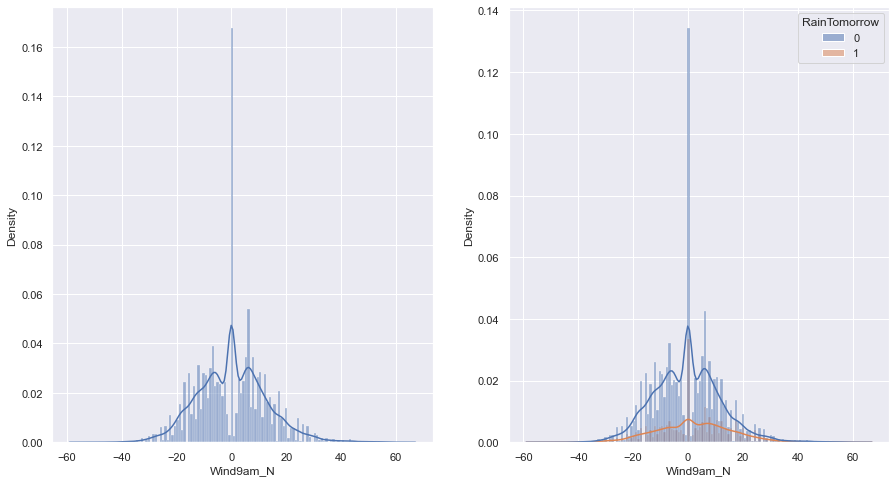

In [129]:
plot_num_var(set1, "Wind9am_N")

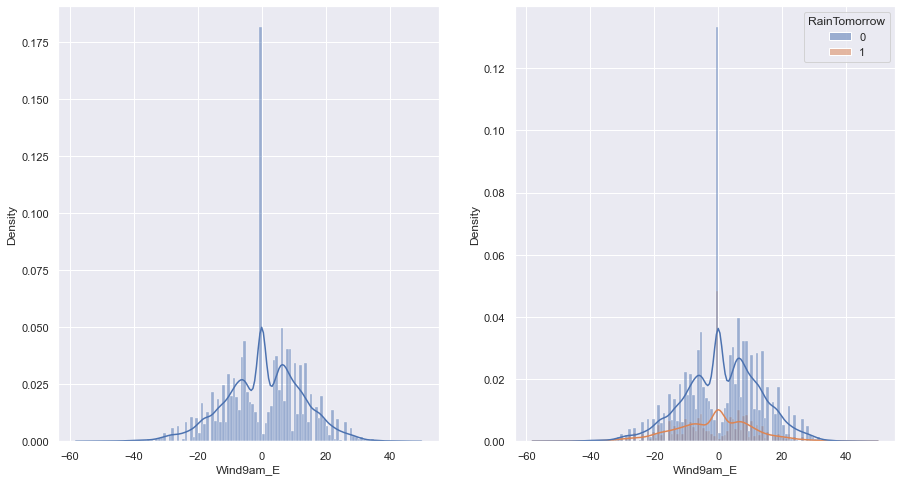

In [131]:
plot_num_var(set1, "Wind9am_E")

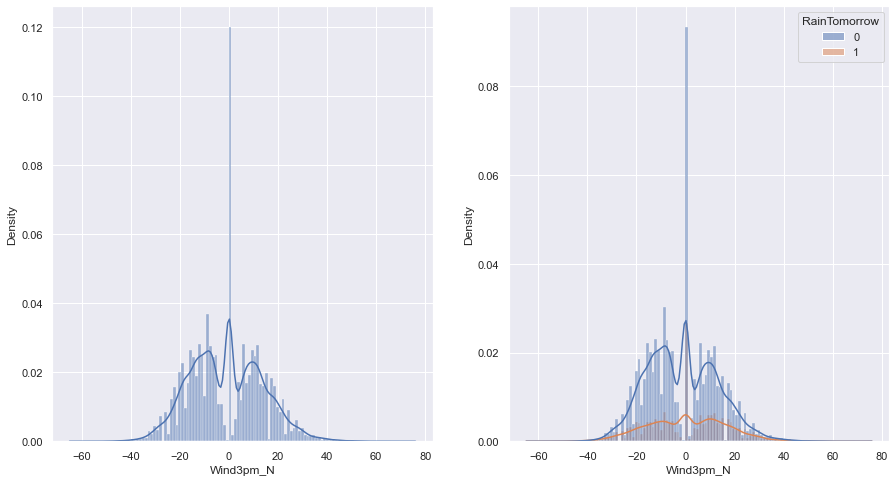

In [133]:
plot_num_var(set1, "Wind3pm_N")

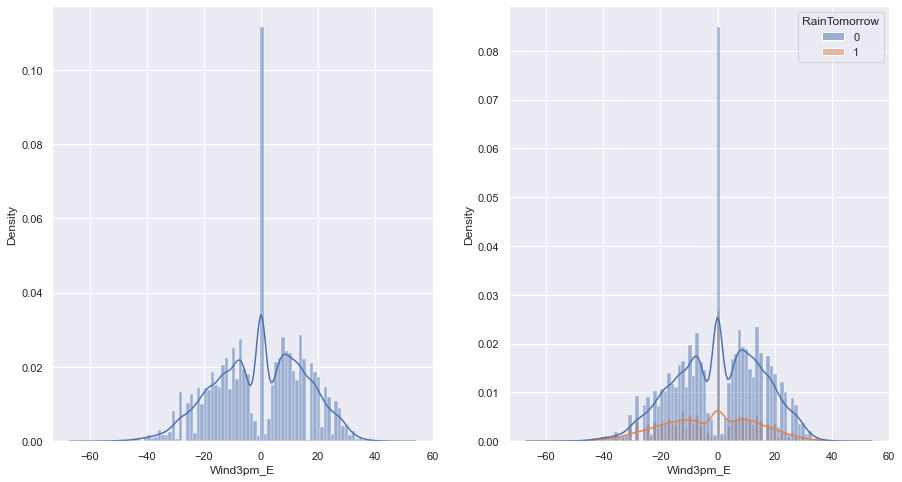

In [134]:
plot_num_var(set1, "Wind3pm_E")

* As seen, neither of these suggest having good predictive power.
* Because of the direction discretization there are large accumulations in the 0 value (E, W dir will give N,S =0 and viceversa)
* Distribution of winds given RainTomorrow seem to be symmetrical, which would suggest we're better off with just the speed and dropping the direction. This is the chosen policy.

In [136]:
set1.drop(columns=["WindGustDir", "WindDir9am", "WindDir3pm", 
                   "WindGust_N", "Wind9am_N", "Wind3pm_N", 
                   "WindGust_E", "Wind9am_E", "Wind3pm_E"], inplace=True)
set1.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,day,month,year
5939,Cobar,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,...,1004.4,2.0,5.0,26.6,33.4,0,0,1,1,2009
5940,Cobar,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,...,1012.1,1.0,1.0,20.3,27.0,0,0,2,1,2009
5942,Cobar,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,...,1009.2,1.0,6.0,28.7,34.9,0,0,4,1,2009
5943,Cobar,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,...,1009.1,1.0,5.0,29.1,35.6,0,0,5,1,2009
5944,Cobar,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,...,1007.4,1.0,6.0,33.6,37.6,0,0,6,1,2009


### Categorical

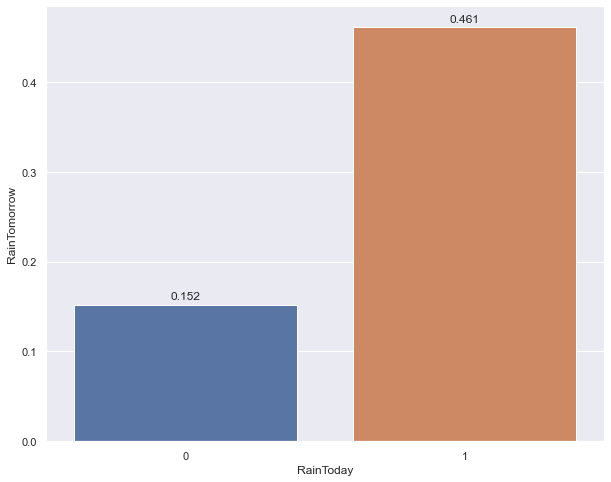

In [143]:
# RainToday
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=set1, x="RainToday", y="RainTomorrow", estimator=np.mean, ax=ax, ci=False)
annotate_bars(ax, round_decs=3)
plt.show()

No surprise, today raining is a big predictor of whether it will tomorrow too.

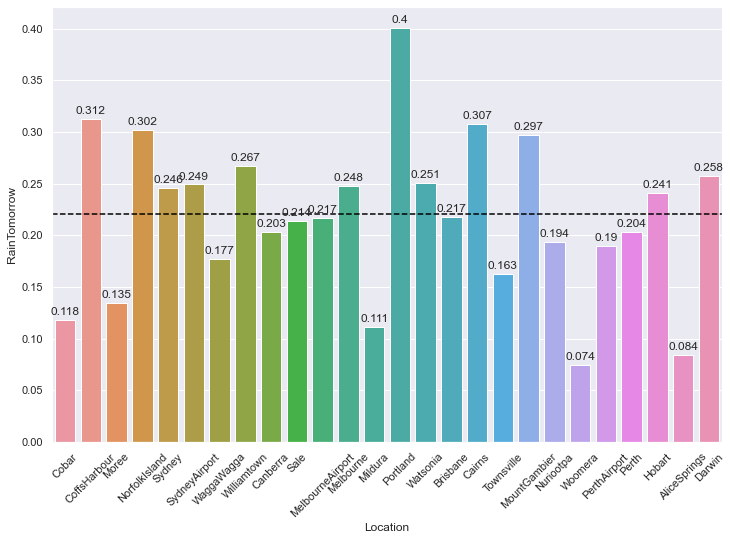

In [151]:
# Location of the weather measurement base
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=set1, x="Location", y="RainTomorrow", estimator=np.mean, ax=ax, ci=False)
annotate_bars(ax, round_decs=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.axhline(y=set1.RainTomorrow.mean(), color="black", linestyle="dashed")
plt.show()

The dashed black line is the set average. As can be seen, some values for Location are pretty good at predicting RainTomorrow (e.g. Cobar, Moree, Mildura, Portland, Woomera, AliceSprings). Even if it's a high-cardinality categorical variable, it should be beneficial to keep it (one-hot encoded).

In [152]:
# making sure we're only affecting Location
set1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 5939 to 139112
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       56420 non-null  object 
 1   MinTemp        56420 non-null  float64
 2   MaxTemp        56420 non-null  float64
 3   Rainfall       56420 non-null  float64
 4   Evaporation    56420 non-null  float64
 5   Sunshine       56420 non-null  float64
 6   WindGustSpeed  56420 non-null  float64
 7   WindSpeed9am   56420 non-null  float64
 8   WindSpeed3pm   56420 non-null  float64
 9   Humidity9am    56420 non-null  float64
 10  Humidity3pm    56420 non-null  float64
 11  Pressure9am    56420 non-null  float64
 12  Pressure3pm    56420 non-null  float64
 13  Cloud9am       56420 non-null  float64
 14  Cloud3pm       56420 non-null  float64
 15  Temp9am        56420 non-null  float64
 16  Temp3pm        56420 non-null  float64
 17  RainToday      56420 non-null  int32  
 18  Ra

In [335]:
# using One-Hot encoding for Location, will not drop first but will then drop MelbourneAirport which is the least useful
def encode_dataset(dataset):
    return (pd.get_dummies(dataset, columns=["Location"], prefix={"Location":"Location"},drop_first=False, sparse=False)
            .drop(columns=["Location_MelbourneAirport"])
           )

encoded_set1 = encode_dataset(set1)
encoded_set1.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Location_PerthAirport,Location_Portland,Location_Sale,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_WaggaWagga,Location_Watsonia,Location_Williamtown,Location_Woomera
5939,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,...,0,0,0,0,0,0,0,0,0,0
5940,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,...,0,0,0,0,0,0,0,0,0,0
5942,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,...,0,0,0,0,0,0,0,0,0,0
5943,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,...,0,0,0,0,0,0,0,0,0,0
5944,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,...,0,0,0,0,0,0,0,0,0,0


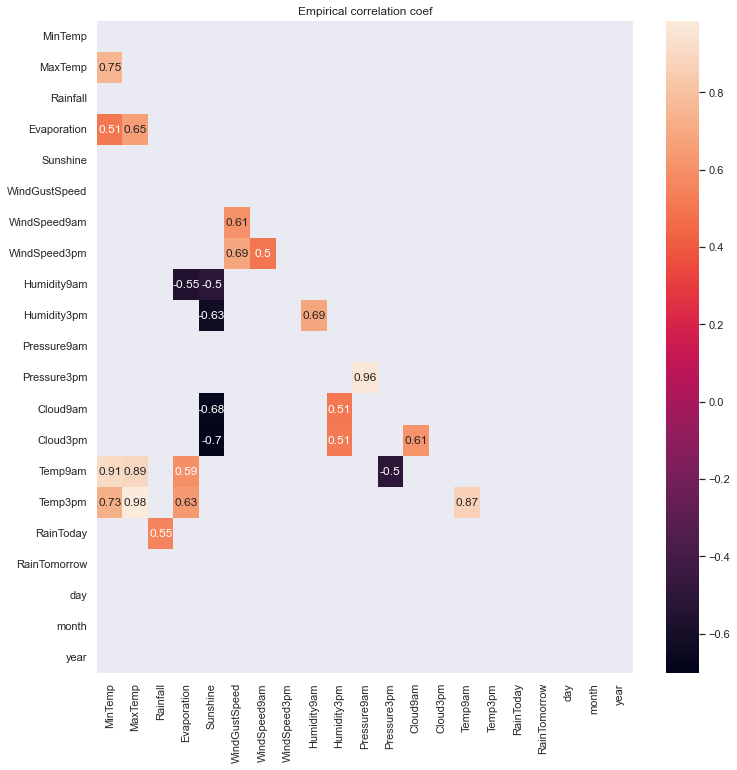

In [187]:
# correlation matrix
non_cat_vars = set1.dtypes[set1.dtypes != "object"].index.to_list()

corr_matrix = set1[non_cat_vars].corr()

# mask upper
trimask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# also mask modulus below 0.5
lowly_correlated = np.abs(corr_matrix) < 0.5

fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(corr_matrix, ax=ax, mask=trimask | lowly_correlated, annot=True)
ax.set_title("Empirical correlation coef")
plt.show()

From the heatmap there are several insights that can be drawn:
* All temperature variables are highly correlated
* Both 9am and 3pm wind variables are highly correlated with Gust one, but not so much between them (0.5 vs 0.6+)
* Pressure variables are almost perfectly correlated (0.96)
* *Sunshine* and Cloud-related variables are highly anticorrelated. *Humidity3pm* is too, but not as highly.

We expect some of the highly correlated variables to not be useful for prediction.

## Model training and evaluation

The models learnt in the course (for binary classification) are:

* LDA/QDA
* Logistic Reggression (and L1, L2 regularized variations)
* Decision Trees (RandomForests may be used)

Because of categorical variables (even if they are one-hot encoded) LDA/QDA are bad options (Normality assumption). We will start with Logistic Reggression and perform feature selection due to high correlations already found.

In [261]:
# perform a train-test split

TARGET_VAR = "RainTomorrow"
X = encoded_set1.drop(columns=[TARGET_VAR])
y = set1[TARGET_VAR]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=13)
len(y_train)

39494

In [236]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Location_PerthAirport,Location_Portland,Location_Sale,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_WaggaWagga,Location_Watsonia,Location_Williamtown,Location_Woomera
82598,19.4,30.4,0.0,4.4,11.4,30.0,7.0,15.0,58.0,57.0,...,0,0,0,0,0,0,0,0,0,0
36245,20.2,36.6,3.4,7.8,11.6,52.0,11.0,11.0,68.0,30.0,...,0,0,0,0,0,0,1,0,0,0
101221,6.5,11.1,6.6,2.6,6.0,56.0,20.0,17.0,83.0,78.0,...,0,0,0,0,0,0,0,0,0,0
100838,7.5,12.1,0.0,1.2,1.4,26.0,11.0,13.0,85.0,55.0,...,0,0,0,0,0,0,0,0,0,0
103655,22.8,38.6,0.0,13.6,8.7,46.0,24.0,22.0,17.0,10.0,...,0,0,0,0,0,0,0,0,0,1


In [237]:
# logistic regression

log_full = LogisticRegression(penalty="none",fit_intercept=True, n_jobs=-1)
log_full.fit(X_train, y_train)
log_full

LogisticRegression(n_jobs=-1, penalty='none')

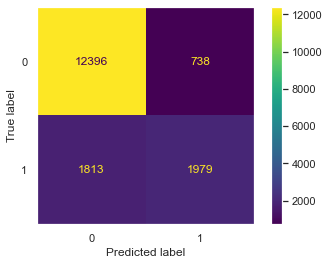

In [239]:
y_hat = log_full.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_hat, labels=log_full.classes_)

disp= ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=log_full.classes_)

disp.plot()
plt.grid(False)
plt.show()

In [242]:
print(f"Precision for full log regression: {precision_score(y_test, y_hat):.3f}")
print(f"Recall for full log regression: {recall_score(y_test, y_hat):.3f}")
print(f"ROC AUC for full log regression: {roc_auc_score(y_test, y_hat):.3f}")

Precision for full log regression: 0.728
Recall for full log regression: 0.522
ROC AUC for full log regression: 0.733


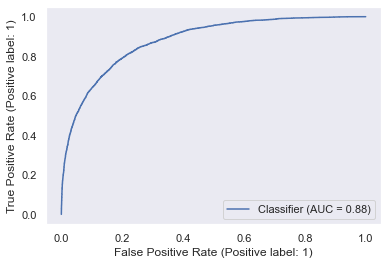

In [243]:
log_full_proba_1 = log_full.predict_proba(X_test)[:,1]
RocCurveDisplay.from_predictions(y_test, log_full_proba_1)
plt.grid(False)
plt.show()

In [245]:
fpr, tpr, thresholds = roc_curve(y_test,log_full_proba_1)

# minimum distance to (0,1) point (max AUC)
log_full_optimal_threshold = thresholds[np.argmin(fpr**2+(1-tpr)**2)]

print(f"ROC-Optimal threshold: {log_full_optimal_threshold}\n")

# re-compute predictions using optimal threshold
def log_predict(binary_log_model, X, threshold=0.5):
    return (binary_log_model.predict_proba(X)[:,1]) >= threshold

y_hat_opt = log_predict(log_full, X_test, log_full_optimal_threshold)

print(f"Precision for full log regression on optimal threshold: {precision_score(y_test, y_hat_opt):.3f}")
print(f"Recall for full log regression on optimal threshold: {recall_score(y_test, y_hat_opt):.3f}")
print(f"AUC for full log regression on optimal threshold: {roc_auc_score(y_test, y_hat_opt):.3f}")

ROC-Optimal threshold: 0.19176981001863525

Precision for full log regression on optimal threshold: 0.520
Recall for full log regression on optimal threshold: 0.808
AUC for full log regression on optimal threshold: 0.796


While precision suffered a lot and it's slightly above chance, recall has greatly increased. This estimator will successfully predict, on average, 4 out of 5 rainy days, but for every predicted rainy day there's only around 52% chance that it will actually rain. We will now move to selecting features through $L_1$ regularization.

In [246]:
log_full.coef_, log_full.intercept_

(array([[-2.49940958e-02,  2.27273307e-02,  2.43076174e-02,
         -2.79661041e-02, -1.42694251e-01,  6.00102327e-02,
         -1.60970132e-02, -2.96084611e-02, -3.35913353e-03,
          6.02360935e-02,  1.93891258e-02, -8.23781224e-02,
          2.90302419e-02,  9.74513214e-02,  2.44851499e-03,
          2.35410016e-02,  9.61142434e-03,  1.93597268e-03,
          2.82863839e-02,  2.84065117e-02, -1.97380667e-04,
          4.45769788e-03,  9.52392675e-04,  3.11555880e-04,
         -2.15416796e-04,  8.86129030e-04, -1.25036427e-03,
         -4.15354397e-03,  4.51837267e-04, -4.07550646e-04,
          7.36507723e-04,  2.03400112e-03, -3.46411353e-03,
          1.46442599e-04,  4.20027746e-03,  3.59897432e-03,
          4.59770284e-04, -2.65590487e-03,  5.81952582e-04,
         -1.11194623e-06, -4.87649985e-03,  1.73764186e-03,
         -1.85343428e-03,  1.47846619e-03,  8.33883221e-05]]),
 array([2.67044851e-05]))

In [291]:
# as can be seen, many coefficients are around 1e-4 through 1e-6
# Python manual "port" of cv.glmnet
# it could be parallelized, but not interesting right now

# score AUC mean+-std interval based on CV for a L1-penalized Logistic Regressor with given C (inverse lambda)
def score_AUC_C(C,X,y,solver):
    scores = cross_val_score(LogisticRegression(penalty='l1',C=C,fit_intercept=True, n_jobs=-1, solver=solver), 
                             X, y, cv=5, scoring="roc_auc")
    mu = scores.mean()
    sigma = scores.std()
    
    return (mu-sigma, mu, mu+sigma)

# we are sure C should get lower than default (1), so we'll increasingly pick lower exponents
exps=-np.arange(-8,20)
Cs = np.exp(exps)
print(Cs)

[2.98095799e+03 1.09663316e+03 4.03428793e+02 1.48413159e+02
 5.45981500e+01 2.00855369e+01 7.38905610e+00 2.71828183e+00
 1.00000000e+00 3.67879441e-01 1.35335283e-01 4.97870684e-02
 1.83156389e-02 6.73794700e-03 2.47875218e-03 9.11881966e-04
 3.35462628e-04 1.23409804e-04 4.53999298e-05 1.67017008e-05
 6.14421235e-06 2.26032941e-06 8.31528719e-07 3.05902321e-07
 1.12535175e-07 4.13993772e-08 1.52299797e-08 5.60279644e-09]


In [281]:
%time score_AUC_C(1, X,y, solver="saga")

Wall time: 41.7 s


(0.8590622295666259, 0.8778485718279662, 0.8966349140893064)

In [268]:
# this took too long, so we favor saga solver
#%time score_AUC_C(1, X,y, solver="liblinear")

In [292]:
results = [score_AUC_C(C, X=X, y=y, solver="saga") for C in tqdm(Cs)]

print(results)

100%|██████████| 28/28 [14:19<00:00, 30.68s/it]

[(0.859067183796432, 0.8778526052073852, 0.8966380266183384), (0.8590649127767633, 0.8778518001707786, 0.8966386875647938), (0.8590714525043596, 0.8778562544756721, 0.8966410564469846), (0.8590681008358457, 0.8778525778698796, 0.8966370549039134), (0.8590692471622907, 0.8778524774581123, 0.896635707753934), (0.8590673344714183, 0.8778519925840789, 0.8966366506967395), (0.859067402702844, 0.877853766618963, 0.896640130535082), (0.859069252163684, 0.8778551019680277, 0.8966409517723715), (0.8590676321649002, 0.8778520108962061, 0.896636389627512), (0.8590635122240435, 0.8778500076944022, 0.896636503164761), (0.859053751111064, 0.8778445653319549, 0.8966353795528458), (0.8590386041109017, 0.8778338732922913, 0.896629142473681), (0.8589840051159927, 0.8778018874350048, 0.8966197697540168), (0.8587963808068574, 0.8776783830268247, 0.8965603852467919), (0.8581079945477857, 0.8771640917011023, 0.8962201888544189), (0.856054332332867, 0.8756297479003164, 0.8952051634677659), (0.850931876738911

In [293]:
lower_ci, means, upper_ci = zip(*results)
means

(0.8778526052073852,
 0.8778518001707786,
 0.8778562544756721,
 0.8778525778698796,
 0.8778524774581123,
 0.8778519925840789,
 0.877853766618963,
 0.8778551019680277,
 0.8778520108962061,
 0.8778500076944022,
 0.8778445653319549,
 0.8778338732922913,
 0.8778018874350048,
 0.8776783830268247,
 0.8771640917011023,
 0.8756297479003164,
 0.8719254888446557,
 0.8555233489537951,
 0.8418268156616502,
 0.8083686101308662,
 0.6856481567432084,
 0.5036142193050875,
 0.5036142193050875,
 0.5036142193050875,
 0.5036142193050875,
 0.5,
 0.5,
 0.5)

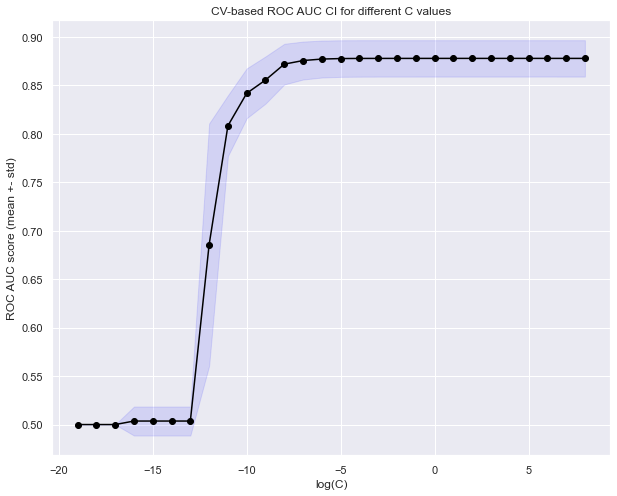

In [294]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(exps, means, color='black',marker='o')
ax.fill_between(exps, lower_ci, upper_ci, color='blue', alpha=.1)
ax.set_xlabel(f"log(C)")
ax.set_ylabel("ROC AUC score (mean +- std)")
ax.set_title("CV-based ROC AUC CI for different C values")
plt.show()

In [298]:
# C that maximizes AUC
idx_max_auc = np.argmax(means)
C_max = Cs[idx_max_auc]

# C that maximizes regularization (min C) s.t. mean AUC value being not further from max mean AUC -1 SD
C_1se = np.min(Cs[means > np.max(lower_ci)])

print(C_max, C_1se)

403.4287934927351 0.00033546262790251185


Taking into account that higher values of C imply lower levels of regularization and higher values of AUC mean better performance, the plot above suggests that there's a limit for how much we can regularize before losing too much predictive power. Also, taking into account the $C=\infty$ case of full regression gave $AUC \approx 0.73$, a decrease in AUC for higher values of log(C) is to be expected. We proceed now to compare the number of surviving variables for each model.

In [300]:
# surviving vars for C_max
log_max = LogisticRegression(C=C_max, penalty='l1', solver='saga',fit_intercept=True, n_jobs=-1, max_iter=1000)
log_max.fit(X_train,y_train)

C:\Users\martinn\.conda\envs\kaggle\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=403.4287934927351, max_iter=1000, n_jobs=-1, penalty='l1',
                   solver='saga')

In [313]:
# surviving vars for C_max
log_1se = LogisticRegression(C=C_1se, penalty='l1', solver='saga',fit_intercept=True, n_jobs=-1, max_iter=1000)
log_1se.fit(X_train,y_train)

LogisticRegression(C=0.00033546262790251185, max_iter=1000, n_jobs=-1,
                   penalty='l1', solver='saga')

In [314]:
log_1se.coef_

array([[ 0.        ,  0.        ,  0.01099222,  0.        , -0.10678781,
         0.04602348, -0.00099025, -0.01547245,  0.00230951,  0.05651214,
         0.        , -0.05161872,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.02328276,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [325]:
print(f"{np.sum(log_1se.coef_ != 0)} variables survived out of {log_1se.coef_.size}")

9 variables survived out of 45


In [317]:
fpr, tpr, thresholds = roc_curve(y_test, log_1se.predict_proba(X_test)[:,1])

# minimum distance to (0,1) point (max AUC)
log_L1_1se_optimal_threshold = thresholds[np.argmin(fpr**2+(1-tpr)**2)]

print(f"ROC-Optimal threshold: {log_L1_1se_optimal_threshold}\n")

y_hat_opt_1se = log_predict(log_1se, X_test, log_L1_1se_optimal_threshold)

print(f"Precision for full log regression on optimal threshold: {precision_score(y_test, y_hat_opt_1se):.3f}")
print(f"Recall for full log regression on optimal threshold: {recall_score(y_test, y_hat_opt_1se):.3f}")
print(f"AUC for full log regression on optimal threshold: {roc_auc_score(y_test, y_hat_opt_1se):.3f}")

ROC-Optimal threshold: 0.21988514694813663

Precision for full log regression on optimal threshold: 0.528
Recall for full log regression on optimal threshold: 0.778
AUC for full log regression on optimal threshold: 0.789


So we have a model that is almost as good as the regression on all the variables, but with only 1/5 of them. These relevant variables are:


In [332]:
remaining_vars = log_1se.feature_names_in_[log_1se.coef_.flatten() != 0]
remaining_betas = log_1se.coef_.flatten()[log_1se.coef_.flatten() != 0]

remaining_vars_betas = {var_name: beta for var_name, beta in zip(remaining_vars, remaining_betas)}
remaining_vars_betas['intercept'] = log_1se.intercept_[0]
remaining_vars_betas

{'Rainfall': 0.010992219343661454,
 'Sunshine': -0.10678780519719236,
 'WindGustSpeed': 0.04602347697687098,
 'WindSpeed9am': -0.0009902453812751448,
 'WindSpeed3pm': -0.01547244968592239,
 'Humidity9am': 0.0023095111901380834,
 'Humidity3pm': 0.056512141359708876,
 'Pressure3pm': -0.051618721819972235,
 'year': 0.023282763884042674,
 'intercept': 0.00028725076657668783}

## Representativity test via Set 2

A repetition of the experiment is performed to test whether conclusions drawn from Set 1 were representative of the dataset. Most notably, the *Sunshine* variable is missing in this set so the $L_1$ regularized Logistic Reggresor will be forced to use other variables.

In [339]:
set2.RainTomorrow = (set2.RainTomorrow == "Yes").astype(int)
set2.RainToday = (set2.RainToday == "Yes").astype(int)
set2.drop(columns=["WindGustDir", "WindDir9am", "WindDir3pm"],inplace=True)
encoded_set2 = encode_dataset(set2)

X2 = encoded_set2.drop(columns=[TARGET_VAR])
y2 = set2[TARGET_VAR]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, 
                                                    test_size=0.3, random_state=13)
len(X_train2)

79047

In [343]:
set(X2.columns) - set(X.columns)

{'Location_Adelaide',
 'Location_Albury',
 'Location_BadgerysCreek',
 'Location_Ballarat',
 'Location_Bendigo',
 'Location_Dartmoor',
 'Location_GoldCoast',
 'Location_Katherine',
 'Location_Launceston',
 'Location_Nhil',
 'Location_NorahHead',
 'Location_PearceRAAF',
 'Location_Richmond',
 'Location_Tuggeranong',
 'Location_Uluru',
 'Location_Walpole',
 'Location_Witchcliffe',
 'Location_Wollongong'}

In [347]:
log2_full = LogisticRegression(penalty="none",fit_intercept=True, n_jobs=-1)
log2_full.fit(X_train2, y_train2)
y_hat2 = log2_full.predict(X_test2)

print(f"Precision for full log regression: {precision_score(y_test2, y_hat2):.3f}")
print(f"Recall for full log regression: {recall_score(y_test2, y_hat2):.3f}")
print(f"ROC AUC for full log regression: {roc_auc_score(y_test2, y_hat2):.3f}")

fpr, tpr, thresholds = roc_curve(y_test2,log2_full.predict_proba(X_test2)[:,1])
log2_full_optimal_threshold = thresholds[np.argmin(fpr**2+(1-tpr)**2)]

print(f"\n\nROC-Optimal threshold: {log2_full_optimal_threshold}\n")

y_hat2_opt = log_predict(log2_full, X_test2, log2_full_optimal_threshold)

print(f"Precision for full log regression on optimal threshold: {precision_score(y_test2, y_hat2_opt):.3f}")
print(f"Recall for full log regression on optimal threshold: {recall_score(y_test2, y_hat2_opt):.3f}")
print(f"AUC for full log regression on optimal threshold: {roc_auc_score(y_test2, y_hat2_opt):.3f}")

Precision for full log regression: 0.718
Recall for full log regression: 0.491
ROC AUC for full log regression: 0.718


ROC-Optimal threshold: 0.20660370551473684

Precision for full log regression on optimal threshold: 0.499
Recall for full log regression on optimal threshold: 0.783
AUC for full log regression on optimal threshold: 0.780


So far we have almost exact same performances for (precision, recall, AUC):

Set | $\theta$ | Precision | Recall | AUC
:---: | :---: | :---: | :---: | :---: 
1 | 0.5 | 0.728 | 0.522 | 0.733
2 | 0.5 | 0.718 | 0.491 | 0.718
1 | 0.1918 | 0.520 | 0.808 | 0.796
2 | 0.2066 | 0.499 | 0.783 | 0.78

In [348]:
results2 = [score_AUC_C(C, X=X2, y=y2, solver="saga") for C in tqdm(Cs)]

100%|██████████| 28/28 [39:26<00:00, 84.53s/it] 


In [349]:
lower_ci2, means2, upper_ci2 = zip(*results2)
means2

(0.8619114799252083,
 0.8619104727989455,
 0.8619106841620532,
 0.861912552910133,
 0.8619119459136193,
 0.8619113298223464,
 0.8619122551113791,
 0.8619103090848267,
 0.8619115344290741,
 0.8619100249363385,
 0.8619071695918443,
 0.8618987013423023,
 0.8618741626412959,
 0.8618105377107446,
 0.8615821203962039,
 0.860839903016678,
 0.8593957827905105,
 0.8566036622049694,
 0.8439379100954933,
 0.8372088513549446,
 0.8082680740093867,
 0.509479020115917,
 0.509479020115917,
 0.509479020115917,
 0.509479020115917,
 0.509479020115917,
 0.5,
 0.5)

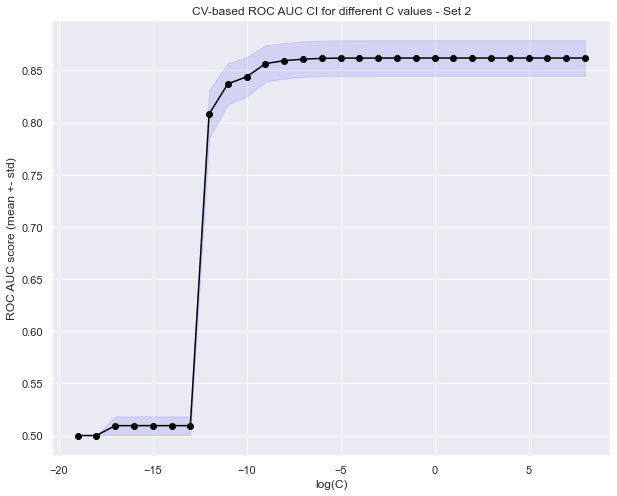

In [351]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(exps, means2, color='black',marker='o')
ax.fill_between(exps, lower_ci2, upper_ci2, color='blue', alpha=.1)
ax.set_xlabel(f"log(C)")
ax.set_ylabel("ROC AUC score (mean +- std)")
ax.set_title("CV-based ROC AUC CI for different C values - Set 2")
plt.show()

In [352]:
# C that maximizes AUC
idx_max_auc2 = np.argmax(means2)
C2_max = Cs[idx_max_auc2]

# C 1se
C2_1se = np.min(Cs[means2 > np.max(lower_ci2)])

print(C2_max, C2_1se)

148.4131591025766 0.00012340980408667956


In [353]:
print("Set1 vs Set2 optimal C values")
print(round(C_max,1), round(C2_max,1))
print(round(C_1se,5), round(C2_1se,5))

Set1 vs Set2 optimal C values
403.4 148.4
0.00034 0.00012


In [354]:
# surviving vars for C_max
log2_1se = LogisticRegression(C=C2_1se, penalty='l1', solver='saga',fit_intercept=True, n_jobs=-1, max_iter=1000)
log2_1se.fit(X_train2,y_train2)

print(f"{np.sum(log2_1se.coef_ != 0)} variables survived out of {log2_1se.coef_.size}")

7 variables survived out of 59


In [355]:
fpr, tpr, thresholds = roc_curve(y_test2, log2_1se.predict_proba(X_test2)[:,1])
log2_L1_1se_optimal_threshold = thresholds[np.argmin(fpr**2+(1-tpr)**2)]

print(f"ROC-Optimal threshold: {log2_L1_1se_optimal_threshold}\n")

y_hat2_opt_1se = log_predict(log2_1se, X_test2, log2_L1_1se_optimal_threshold)

print(f"Precision for full log regression on optimal threshold: {precision_score(y_test2, y_hat2_opt_1se):.3f}")
print(f"Recall for full log regression on optimal threshold: {recall_score(y_test2, y_hat2_opt_1se):.3f}")
print(f"AUC for full log regression on optimal threshold: {roc_auc_score(y_test2, y_hat2_opt_1se):.3f}")

ROC-Optimal threshold: 0.21881810891626843

Precision for full log regression on optimal threshold: 0.492
Recall for full log regression on optimal threshold: 0.781
AUC for full log regression on optimal threshold: 0.776


Final model performance comparison for both sets:

Set | #variables | $C_{1SE}$ | $\theta$ | Precision | Recall | AUC
:---: | :---: | :---: | :---: | :---: | :---: | :---: 
1 | 9 | 0.00034 | 0.2199 | 0.528 | 0.778 | 0.789
2 | 7| 0.00012 | 0.2188 | 0.492 | 0.781 | 0.776


The relative differences for Precision, Recall and AUC are approximately 6.82, 0.39 and 1.65 %, meaning they are very similar, while the second model uses even less variables.

In [356]:
remaining_vars2 = log2_1se.feature_names_in_[log2_1se.coef_.flatten() != 0]
remaining_betas2 = log2_1se.coef_.flatten()[log2_1se.coef_.flatten() != 0]

remaining_vars_betas2 = {var_name: beta for var_name, beta in zip(remaining_vars2, remaining_betas2)}
remaining_vars_betas2['intercept'] = log2_1se.intercept_[0]
remaining_vars_betas2

{'Rainfall': 0.008887717032235554,
 'WindGustSpeed': 0.04839552794426735,
 'WindSpeed3pm': -0.0184852134621589,
 'Humidity9am': 0.006943346078405124,
 'Humidity3pm': 0.06305734499927851,
 'Pressure3pm': -0.04128566276008641,
 'year': 0.017320221985138405,
 'intercept': 0.00010883563459536426}

In [363]:
all_remaining_vars = sorted(set(remaining_vars) | set(remaining_vars2))

pd.DataFrame({"Set 1": [remaining_vars_betas.get(k, "-") for k in all_remaining_vars],
              "Set 2": [remaining_vars_betas2.get(k, "N/C" if k in high_NA_variables else "-") for k in all_remaining_vars]
             }, 
            index=all_remaining_vars)

,Set 1,Set 2
Humidity3pm,0.056512,0.063057
Humidity9am,0.002310,0.006943
Pressure3pm,-0.051619,-0.041286
Rainfall,0.010992,0.008888
Sunshine,-0.106788,N/C
WindGustSpeed,0.046023,0.048396
WindSpeed3pm,-0.015472,-0.018485
WindSpeed9am,-0.000990,-
year,0.023283,0.01732


From the table we can also verify that the variables are almost the same (*Sunshine* is not included in Set2), with the exception of WindSpeed9am that was discarded by regularization in the second set.

Not only that, but all the predictors have similar values between sets, confirming representativeness of Set1 and the usefulness of a very simple model consisting of only Humidity, Pressure, Wind speed, and Rainfall measurements (+ year). Such model has pretty high recall (\~0.8) while precision is not so high (\~0.5).

Interestingly, neither notorious Locations nor the *RainToday* variable survived (mildly correlated *Rainfall* did though), serving as an example that sometimes variables that look one way as standalone predictors are not as good when grouped with others.